/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model across multiple GPUs...


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 30/30 [01:14<00:00,  2.49s/it]


Model loaded successfully.
Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 33/33 [00:00<00:00, 100.57it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 51/51 [00:00<00:00, 107.94it/s]


Data successfully split into training and test sets.


Training Epochs:   0%|          | 10/2000 [00:00<00:26, 74.45it/s]

Epoch 10/2000, Loss: 0.3589
Test Accuracy: 71.64%, F1-score: 0.4242
New best model saved with Accuracy 71.64%.
New best model saved with F1-score 0.4242.
Epoch 20/2000, Loss: 0.3458
Test Accuracy: 82.09%, F1-score: 0.7000
New best model saved with Accuracy 82.09%.
New best model saved with F1-score 0.7000.
Epoch 30/2000, Loss: 0.3027
Test Accuracy: 91.04%, F1-score: 0.8696


Training Epochs:   2%|▏         | 30/2000 [00:00<00:18, 106.96it/s]

New best model saved with Accuracy 91.04%.
New best model saved with F1-score 0.8696.
Epoch 40/2000, Loss: 0.2526
Test Accuracy: 76.12%, F1-score: 0.7500
Epoch 50/2000, Loss: 0.2878
Test Accuracy: 77.61%, F1-score: 0.7619
Epoch 60/2000, Loss: 0.2708
Test Accuracy: 88.06%, F1-score: 0.8400
Epoch 70/2000, Loss: 0.2435
Test Accuracy: 91.04%, F1-score: 0.8696
Epoch 80/2000, Loss: 0.2171
Test Accuracy: 89.55%, F1-score: 0.8727


Training Epochs:   4%|▍         | 80/2000 [00:00<00:07, 246.27it/s]

New best model saved with F1-score 0.8727.
Epoch 90/2000, Loss: 0.2010
Test Accuracy: 86.57%, F1-score: 0.8302
Epoch 100/2000, Loss: 0.1864
Test Accuracy: 86.57%, F1-score: 0.8163
Epoch 110/2000, Loss: 0.1783
Test Accuracy: 91.04%, F1-score: 0.8696
Epoch 120/2000, Loss: 0.1707
Test Accuracy: 91.04%, F1-score: 0.8696


Training Epochs:   7%|▋         | 145/2000 [00:00<00:04, 381.43it/s]

Epoch 130/2000, Loss: 0.1794
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 140/2000, Loss: 0.2472
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 150/2000, Loss: 0.2234
Test Accuracy: 82.09%, F1-score: 0.7931
Epoch 160/2000, Loss: 0.1678
Test Accuracy: 82.09%, F1-score: 0.7931
Epoch 170/2000, Loss: 0.1440
Test Accuracy: 77.61%, F1-score: 0.7273
Epoch 180/2000, Loss: 0.1880
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 190/2000, Loss: 0.1693
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 200/2000, Loss: 0.1564
Test Accuracy: 85.07%, F1-score: 0.8214


Training Epochs:  10%|█         | 210/2000 [00:00<00:03, 462.21it/s]

Epoch 210/2000, Loss: 0.1358
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 220/2000, Loss: 0.1245
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 230/2000, Loss: 0.1119
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 240/2000, Loss: 0.1019
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 250/2000, Loss: 0.0958
Test Accuracy: 83.58%, F1-score: 0.8136


Training Epochs:  14%|█▍        | 279/2000 [00:00<00:03, 533.44it/s]

Epoch 260/2000, Loss: 0.0912
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 270/2000, Loss: 0.0870
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 280/2000, Loss: 0.0830
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 290/2000, Loss: 0.0806
Test Accuracy: 83.58%, F1-score: 0.8136
Epoch 300/2000, Loss: 0.3880
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 310/2000, Loss: 0.3513
Test Accuracy: 79.10%, F1-score: 0.6316
Epoch 320/2000, Loss: 0.3429
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 330/2000, Loss: 0.3368
Test Accuracy: 71.64%, F1-score: 0.7164
Epoch 340/2000, Loss: 0.3280
Test Accuracy: 83.58%, F1-score: 0.8136


Training Epochs:  18%|█▊        | 350/2000 [00:00<00:03, 490.80it/s]

Epoch 350/2000, Loss: 0.3135
Test Accuracy: 95.52%, F1-score: 0.9388
New best model saved with Accuracy 95.52%.
New best model saved with F1-score 0.9388.


Training Epochs:  21%|██▏       | 425/2000 [00:00<00:02, 560.29it/s]

Epoch 360/2000, Loss: 0.2899
Test Accuracy: 89.55%, F1-score: 0.8727
Epoch 370/2000, Loss: 0.2609
Test Accuracy: 95.52%, F1-score: 0.9388
Epoch 380/2000, Loss: 0.3264
Test Accuracy: 71.64%, F1-score: 0.7164
Epoch 390/2000, Loss: 0.3370
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 400/2000, Loss: 0.3298
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 410/2000, Loss: 0.3238
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 420/2000, Loss: 0.3174
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 430/2000, Loss: 0.3065
Test Accuracy: 67.16%, F1-score: 0.6857
Epoch 440/2000, Loss: 0.3009
Test Accuracy: 71.64%, F1-score: 0.7164
Epoch 450/2000, Loss: 0.3055


Training Epochs:  25%|██▍       | 494/2000 [00:01<00:02, 595.32it/s]

Test Accuracy: 64.18%, F1-score: 0.6667
Epoch 460/2000, Loss: 0.3008
Test Accuracy: 71.64%, F1-score: 0.7164
Epoch 470/2000, Loss: 0.2862
Test Accuracy: 80.60%, F1-score: 0.7869
Epoch 480/2000, Loss: 0.3007
Test Accuracy: 71.64%, F1-score: 0.7164
Epoch 490/2000, Loss: 0.2758
Test Accuracy: 80.60%, F1-score: 0.7869
Epoch 500/2000, Loss: 0.2586
Test Accuracy: 80.60%, F1-score: 0.7869


Training Epochs:  28%|██▊       | 564/2000 [00:01<00:02, 624.30it/s]

Epoch 510/2000, Loss: 0.2551
Test Accuracy: 89.55%, F1-score: 0.8727
Epoch 520/2000, Loss: 0.3135
Test Accuracy: 86.57%, F1-score: 0.7907
Epoch 530/2000, Loss: 0.3534
Test Accuracy: 88.06%, F1-score: 0.8182
Epoch 540/2000, Loss: 0.3036
Test Accuracy: 86.57%, F1-score: 0.8163
Epoch 550/2000, Loss: 0.3190
Test Accuracy: 91.04%, F1-score: 0.8696
Epoch 560/2000, Loss: 0.3444
Test Accuracy: 95.52%, F1-score: 0.9388
Epoch 570/2000, Loss: 0.3579
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 580/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 590/2000, Loss: 0.3614
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  32%|███▏      | 635/2000 [00:01<00:02, 647.70it/s]

Epoch 600/2000, Loss: 0.3609
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 610/2000, Loss: 0.3589
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 620/2000, Loss: 0.3560
Test Accuracy: 82.09%, F1-score: 0.7000
Epoch 630/2000, Loss: 0.3486
Test Accuracy: 86.57%, F1-score: 0.7907
Epoch 640/2000, Loss: 0.3560
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  35%|███▌      | 702/2000 [00:01<00:02, 642.59it/s]

Epoch 650/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 660/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 670/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 680/2000, Loss: 0.3605
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 690/2000, Loss: 0.3594
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 700/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 710/2000, Loss: 0.3556
Test Accuracy: 82.09%, F1-score: 0.7000
Epoch 720/2000, Loss: 0.3502
Test Accuracy: 89.55%, F1-score: 0.8444
Epoch 730/2000, Loss: 0.3429
Test Accuracy: 85.07%, F1-score: 0.8077
Epoch 740/2000, Loss: 0.3351
Test Accuracy: 97.01%, F1-score: 0.9600
New best model saved with Accuracy 97.01%.


Training Epochs:  38%|███▊      | 768/2000 [00:01<00:02, 560.24it/s]

New best model saved with F1-score 0.9600.
Epoch 750/2000, Loss: 0.3595
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 760/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 770/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 780/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 790/2000, Loss: 0.3612
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 800/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 810/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 820/2000, Loss: 0.3639
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 830/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  42%|████▏     | 835/2000 [00:01<00:01, 588.20it/s]

Epoch 840/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 850/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 860/2000, Loss: 0.3606
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 870/2000, Loss: 0.3589
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  49%|████▊     | 974/2000 [00:01<00:01, 640.72it/s]

Epoch 880/2000, Loss: 0.3548
Test Accuracy: 82.09%, F1-score: 0.7000
Epoch 890/2000, Loss: 0.3607
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 900/2000, Loss: 0.3572
Test Accuracy: 80.60%, F1-score: 0.6667
Epoch 910/2000, Loss: 0.3607
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 920/2000, Loss: 0.3599
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 930/2000, Loss: 0.3583
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 940/2000, Loss: 0.3539
Test Accuracy: 83.58%, F1-score: 0.7317
Epoch 950/2000, Loss: 0.3476
Test Accuracy: 89.55%, F1-score: 0.8727
Epoch 960/2000, Loss: 0.3534
Test Accuracy: 62.69%, F1-score: 0.6575
Epoch 970/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 980/2000, Loss: 0.3609
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 990/2000, Loss: 0.3580
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1000/2000, Loss: 0.3561
Test Accuracy: 95.52%, F1-score: 0.9388
Epoch 1010/2000, Loss: 0.3509
Test Accuracy: 83.58%, F1-score: 0.7317
Epoch 1020/2000, Loss: 0.3470
Te

Training Epochs:  56%|█████▌    | 1113/2000 [00:02<00:01, 666.96it/s]

Epoch 1030/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1040/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1050/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1060/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1070/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1080/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1090/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1100/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1110/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1120/2000, Loss: 0.3616
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1130/2000, Loss: 0.3591
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1140/2000, Loss: 0.3602
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1150/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  59%|█████▉    | 1181/2000 [00:02<00:01, 641.17it/s]

Epoch 1160/2000, Loss: 0.3615
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1170/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1180/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1190/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1200/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1210/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1220/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1230/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  62%|██████▏   | 1246/2000 [00:02<00:01, 637.01it/s]

Epoch 1240/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1250/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1260/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1270/2000, Loss: 0.3618
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1280/2000, Loss: 0.3581
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  66%|██████▌   | 1311/2000 [00:02<00:01, 630.98it/s]

Epoch 1290/2000, Loss: 0.3617
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1300/2000, Loss: 0.3615
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1310/2000, Loss: 0.3487
Test Accuracy: 86.57%, F1-score: 0.7907
Epoch 1320/2000, Loss: 0.4740
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1330/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1340/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1350/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1360/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  69%|██████▉   | 1376/2000 [00:02<00:00, 635.54it/s]

Epoch 1370/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1380/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1390/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1400/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1410/2000, Loss: 0.3620
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  72%|███████▏  | 1440/2000 [00:02<00:00, 610.51it/s]

Epoch 1420/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1430/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1440/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1450/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1460/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1470/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1480/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1490/2000, Loss: 0.3617
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  75%|███████▌  | 1506/2000 [00:02<00:00, 623.93it/s]

Epoch 1500/2000, Loss: 0.3613
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1510/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1520/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1530/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1540/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  78%|███████▊  | 1569/2000 [00:02<00:00, 623.90it/s]

Epoch 1550/2000, Loss: 0.3611
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1560/2000, Loss: 0.3579
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1570/2000, Loss: 0.3616
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1580/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1590/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1600/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1610/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1620/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143


Training Epochs:  82%|████████▏ | 1632/2000 [00:02<00:00, 622.51it/s]

Epoch 1630/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1640/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1650/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1660/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1670/2000, Loss: 0.3615
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1680/2000, Loss: 0.3619


Training Epochs:  85%|████████▌ | 1700/2000 [00:02<00:00, 626.60it/s]

Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1690/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1700/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1710/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1720/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1730/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1740/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1750/2000, Loss: 0.3619
Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1760/2000, Loss: 0.3619


Training Epochs:  88%|████████▊ | 1769/2000 [00:03<00:00, 643.80it/s]

Test Accuracy: 74.63%, F1-score: 0.5143
Epoch 1770/2000, Loss: 0.3617
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1780/2000, Loss: 0.3611
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1790/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1800/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1810/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242


Training Epochs:  92%|█████████▏| 1834/2000 [00:03<00:00, 632.60it/s]

Epoch 1820/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1830/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1840/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1850/2000, Loss: 0.3616
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1860/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1870/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1880/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1890/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242


Training Epochs:  95%|█████████▌| 1904/2000 [00:03<00:00, 651.83it/s]

Epoch 1900/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1910/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1920/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1930/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1940/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1950/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242


Training Epochs: 100%|██████████| 2000/2000 [00:03<00:00, 583.87it/s]

Epoch 1960/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1970/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1980/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 1990/2000, Loss: 0.3619
Test Accuracy: 71.64%, F1-score: 0.4242
Epoch 2000/2000, Loss: 0.3617
Test Accuracy: 71.64%, F1-score: 0.4242


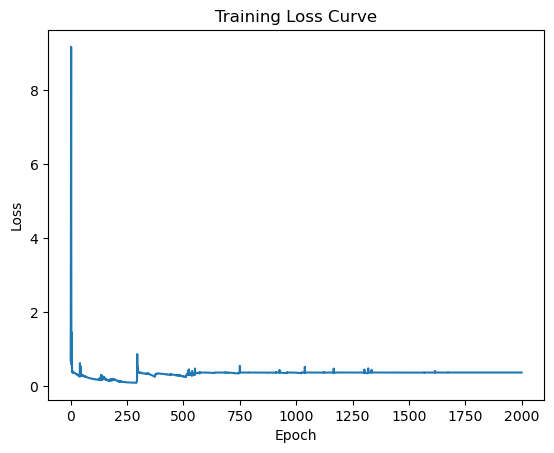

Training complete. Best Accuracy: 97.01%, Best F1-score: 0.9600


In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"

# Variables
model_name = '/raid/data/guangwei/huggingface/hub/models--meta-llama--Llama-3.1-70B/snapshots/349b2ddb53ce8f2849a6c168a81980ab25258dac/'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_70B_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_70B_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

# Define CustomMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)


# 提取隐藏状态
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: val.to("cuda") for key, val in inputs.items()}  # 移动到 GPU
        with torch.no_grad():
            outputs = model(**inputs)
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :].cpu().numpy()  # 最后一个token的隐藏状态
        hidden_states.append(last_token_hidden_states)
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the pooler output (for sequence classification tasks, typically the [CLS] token)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

# Load data for infringement & non-infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

# 加载模型
def load_large_model(model_name):
    """加载超大模型并在多卡上分布"""
    print("Loading model across multiple GPUs...")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="balanced",  # 自动平衡分布到多张 GPU
        offload_folder="offload",  # 如果显存不足，部分权重会被卸载到磁盘
        offload_state_dict=True,
        output_hidden_states=True
    )
    print("Model loaded successfully.")
    return model


def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim).to("cuda")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to("cuda")
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to("cuda")

    best_f1 = -float('inf')  # 初始化最佳 F1 分数
    best_accuracy = -float('inf')  # 初始化最佳准确率
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            # 测试模型
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to("cuda")
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().cpu().numpy()

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            print(f"Test Accuracy: {accuracy * 100:.2f}%, F1-score: {f1:.4f}")
            
            # 更新最佳准确率和F1分数
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(custom_mlp.state_dict(), checkpoint_path)  # 保存模型
                print(f"New best model saved with Accuracy {best_accuracy * 100:.2f}%.")

            if f1 > best_f1:
                best_f1 = f1
                torch.save(custom_mlp.state_dict(), checkpoint_path)  # 保存模型
                print(f"New best model saved with F1-score {best_f1:.4f}.")

    # 绘制训练损失曲线
    plt.plot(losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    return custom_mlp, best_accuracy, best_f1


# 加载数据
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = load_large_model(model_name)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)

# Extract hidden states and reference embeddings
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

# Split data into train and test sets
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

# 定义参数并训练
input_dim = X_train.shape[1]
hidden_dim = 256

trained_model, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)
print(f"Training complete. Best Accuracy: {best_accuracy * 100:.2f}%, Best F1-score: {best_f1:.4f}")

# # Save checkpoint
# def save_checkpoint(model, optimizer, epoch, loss, filepath):
#     checkpoint = {
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss
#     }
#     torch.save(checkpoint, filepath)
#     print(f"Checkpoint saved to '{filepath}'.")

# save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

# # Final predictions
# y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32).to('cuda')))) > 0.5).float().cpu().numpy()
# print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))
